#<center>Titanic - Machine Learning from Disaster</center>

**<center>Notebook 1: EDA + LogisticRegression</center>**

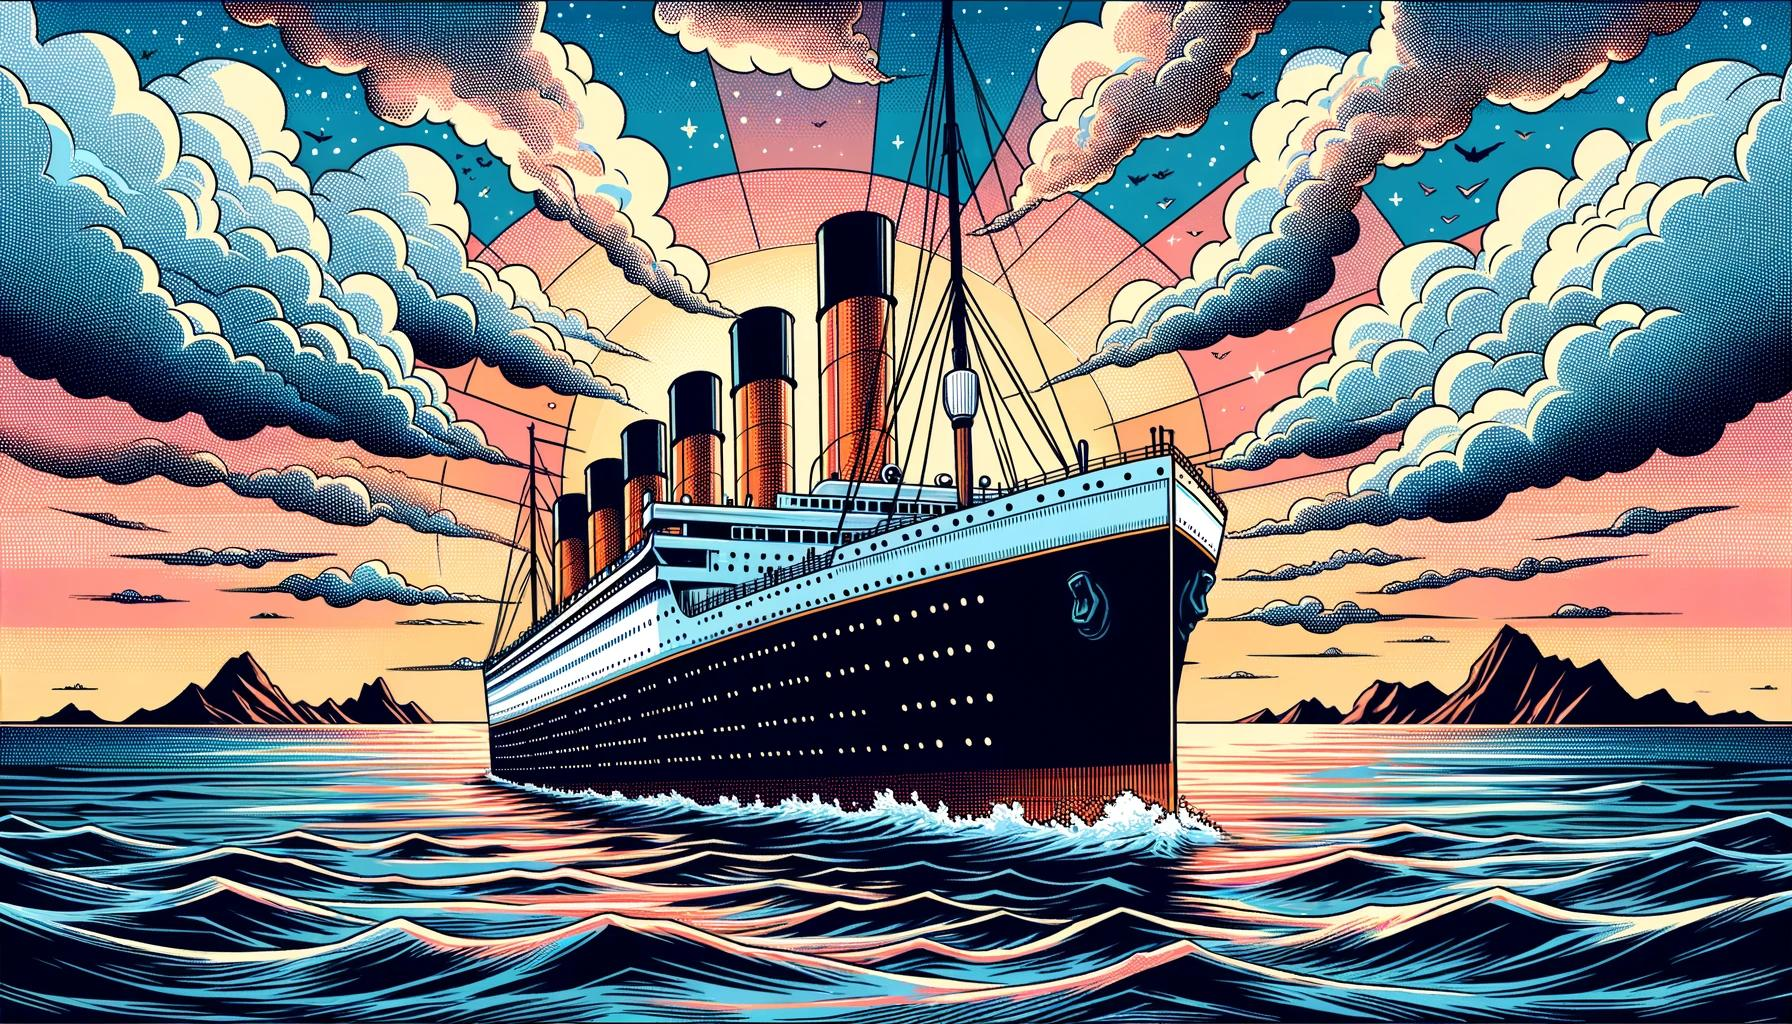

## The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Dataset Description

### Overview
The data has been split into two groups:

1. **Training set (`train.csv`)**: This set should be used to build your machine learning models. The training set provides the outcome (also known as the "ground truth") for each passenger. Your model will be based on "features" like passengers' gender and class. You can also use feature engineering to create new features.

2. **Test set (`test.csv`)**: This set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include `gender_submission.csv`, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Data Dictionary
| Variable  | Definition                       | Key                                       |
|-----------|----------------------------------|-------------------------------------------|
| survival  | Survival                         | 0 = No, 1 = Yes                           |
| pclass    | Ticket class                     | 1 = 1st, 2 = 2nd, 3 = 3rd                 |
| sex       | Sex                              |                                           |
| Age       | Age in years                     |                                           |
| sibsp     | # of siblings / spouses aboard   |                                           |
| parch     | # of parents / children aboard   |                                           |
| ticket    | Ticket number                    |                                           |
| fare      | Passenger fare                   |                                           |
| cabin     | Cabin number                     |                                           |
| embarked  | Port of Embarkation              | C = Cherbourg, Q = Queenstown, S = Southampton |

#### Variable Notes
- **pclass**: A proxy for socio-economic status (SES)
  - 1st = Upper
  - 2nd = Middle
  - 3rd = Lower
- **age**: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5
- **sibsp**: The dataset defines family relations in this way:
  - Sibling = brother, sister, stepbrother, stepsister
  - Spouse = husband, wife (mistresses and fiancés were ignored)
- **parch**: The dataset defines family relations in this way:
  - Parent = mother, father
  - Child = daughter, son, stepdaughter, stepson
  - Some children traveled only with a nanny, therefore parch=0 for them.


## Import libraries

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Show columns without truncate
pd.set_option('display.max_colwidth', None)
# Show all columns
pd.set_option('display.max_columns', None)


## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step before diving into machine learning or statistical modeling. It helps us understand the nature of the data, identify patterns, spot anomalies, and form hypotheses.

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Formació/Data Science + Machine Learning/Kaggle/data/titanic/train.csv')

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Dataframe info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's remove the following columns from the dataset:
- `PassengerId`: Passenger ID, not useful for our analysis
- `Name`: Passenger name, not useful for our analysis
- `Ticket`: Ticket number, not useful for our analysis
- `Cabin`: Cabin number, it has too many missing values
- `Embarked`: Port of Embarkation, not useful for our analysi

In [ ]:
# Let's separate the features from the target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'

# Let's select only the features we want and the target for data analysis
train_df = train_df[features + [target]]

### 1. Basic Stadistics

In [ ]:
# Generate summary stadistics for numerical columns
train_df.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


- **Pclass**: Ranges from 1 to 3. The mean is around 2.31, indicating that there are more passengers in the lower classes.
- **Age**: Ranges from 0.42 to 80 years. The mean age is approximately 29.7 years. Note that the count is less than the total number of passengers, indicating missing values.
- **SibSp**: Ranges from 0 to 8. The mean is approximately 0.52, indicating that most passengers did not have siblings or spouses aboard.
- **Parch**: Ranges from 0 to 6. The mean is around 0.38, suggesting that most passengers were not traveling with parents or children.
- **Fare**: Ranges from 0 to 512.33. The mean fare is approximately 32.2. The standard deviation is high, indicating a wide range of fares.

### 2. Missing Values

In [ ]:
missing_values = train_df.isnull().sum()
print(missing_values)

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Survived      0
dtype: int64


We have 177 missing values in the `Age` column.

### 3. Distribution numerical features

Let's plot histograms for the numerical features.

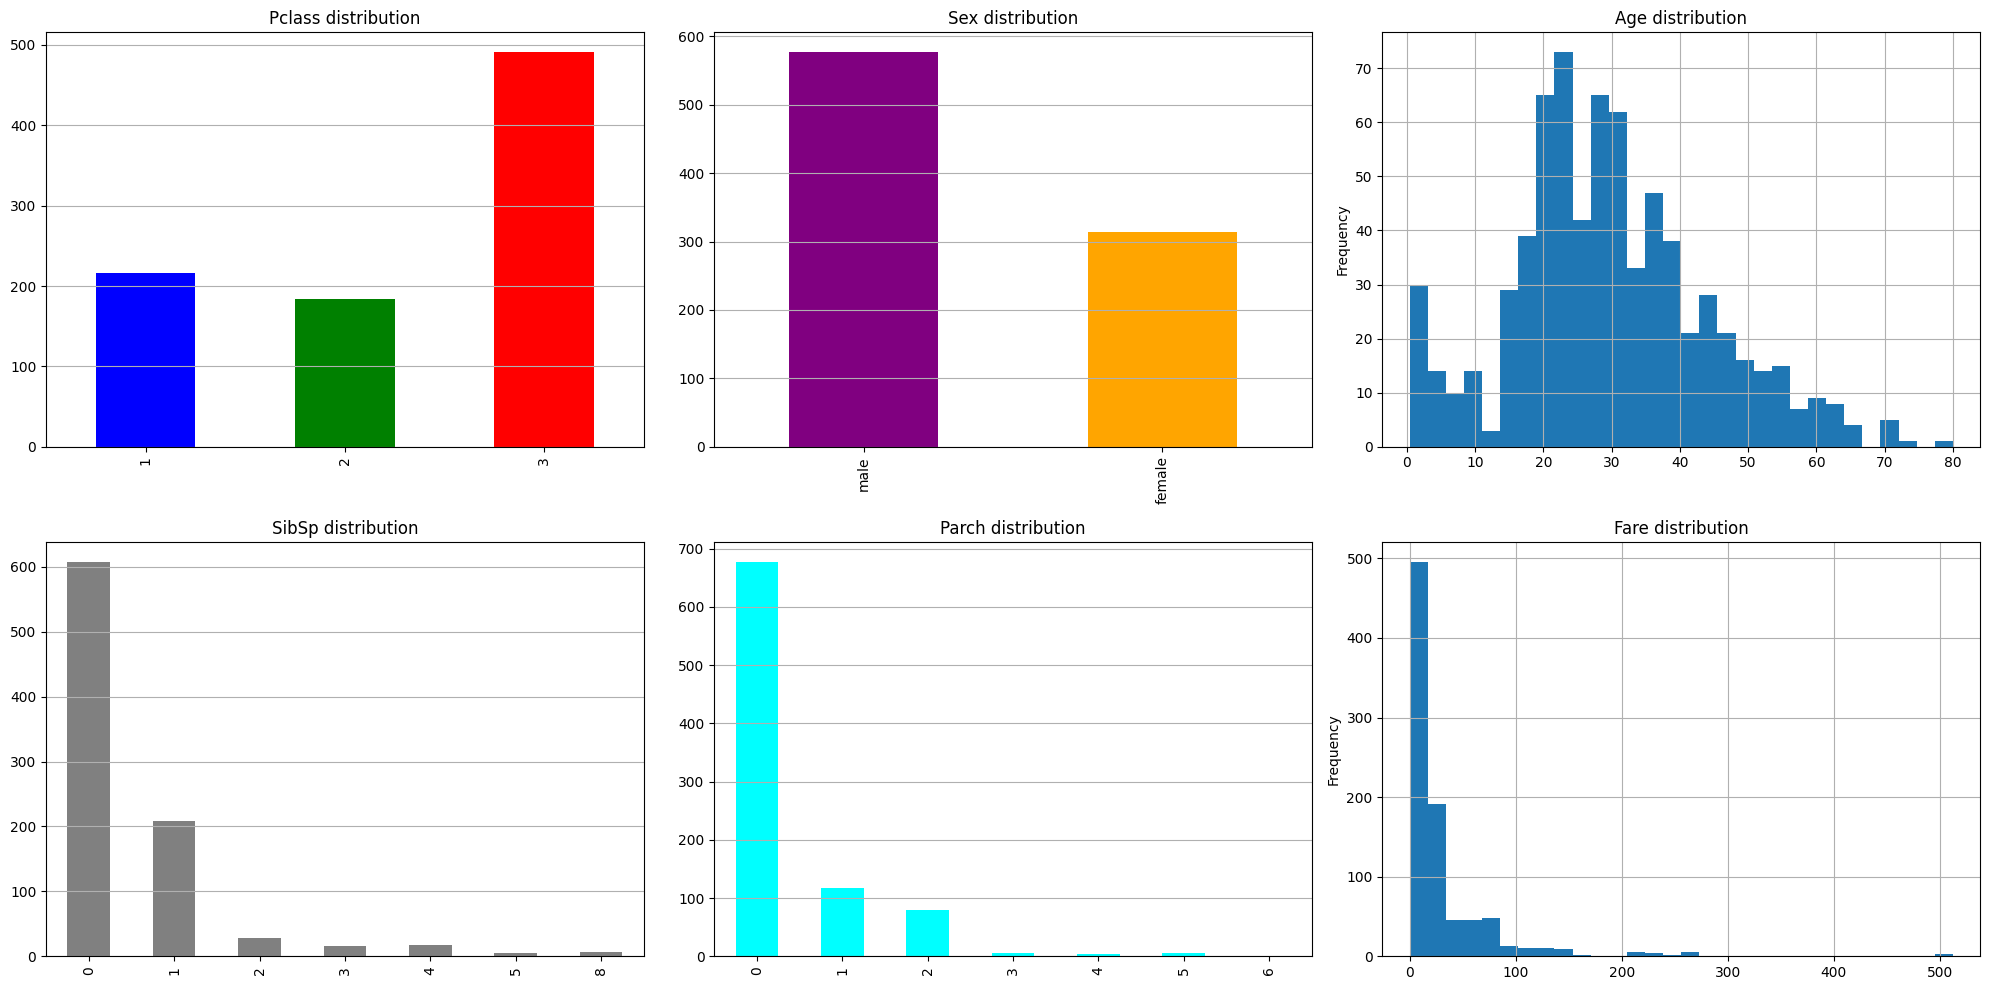

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

colors = {
    'Pclass': ['blue', 'green', 'red'],
    'Sex': ['purple', 'orange'],
    'SibSp': ['gray'] * train_df['SibSp'].nunique(),
    'Parch': ['cyan'] * train_df['Parch'].nunique()
}

# Pclass distribution
train_df['Pclass'].value_counts().sort_index().plot(kind='bar', ax=ax[0, 0], title='Pclass distribution', color=colors['Pclass'], grid=True)
ax[0, 0].grid(axis='x')
# Sex distribution
train_df['Sex'].value_counts().plot(kind='bar', ax=ax[0][1], title="Sex distribution", color=colors['Sex'], grid=True)
ax[0, 1].grid(axis='x')
# Age distribution
train_df['Age'].plot(kind='hist', ax=ax[0][2], bins=30, title="Age distribution", grid=True)
# SibSp distribution
train_df['SibSp'].value_counts().sort_index().plot(kind='bar', ax=ax[1][0], title="SibSp distribution", color=colors['SibSp'], grid=True)
ax[1, 0].grid(axis='x')
# Parch distribution
train_df['Parch'].value_counts().sort_index().plot(kind='bar', ax=ax[1][1], title="Parch distribution", color=colors['Parch'], grid=True)
ax[1, 1].grid(axis='x')
# Fare distribution
train_df['Fare'].plot(kind='hist', ax=ax[1][2], bins=30, title="Fare distribution", grid=True)

plt.tight_layout()
plt.show()

- **Pclass Distribution**: Most passengers are in the 3rd class, followed by 1st and 2nd class.
- **Sex Distribution**: There are more male passengers than female passengers.
- **Age Distribution**: The majority of passengers are in the age range of 20-40 years. The distribution is slightly right-skewed with a smaller number of elderly passengers.
- **SibSp Distribution**: Most passengers traveled without siblings or spouses, with fewer passengers having one or more siblings/spouses.
- **Parch Distribution**: Similarly, most passengers traveled without parents or children aboard.
- **Fare Distribution**: Most fares are on the lower side, with a few passengers paying significantly higher fares. This distribution is right-skewed, indicating potential outliers on the higher side.

Let's create box plots for the numerical features.

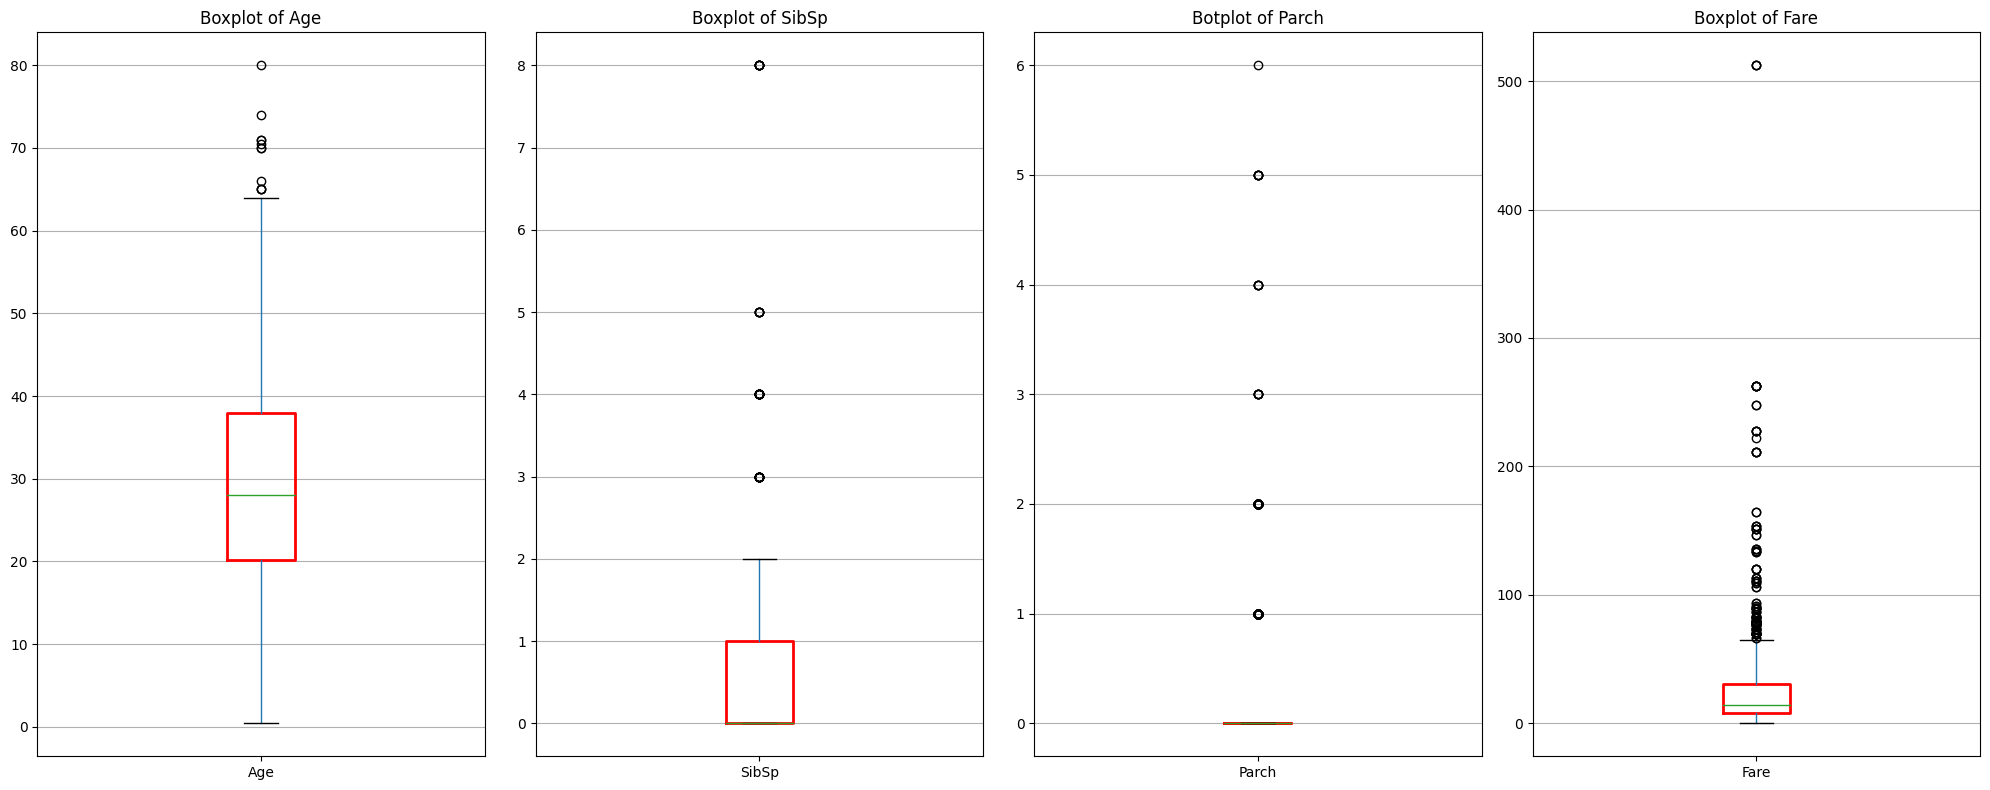

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))

train_df.boxplot(column="Age", ax=ax[0], boxprops=dict(linestyle='-', linewidth=2, color='red'))
train_df.boxplot(column="SibSp", ax=ax[1], boxprops=dict(linestyle='-', linewidth=2, color='red'))
train_df.boxplot(column="Parch", ax=ax[2], boxprops=dict(linestyle='-', linewidth=2, color='red'))
train_df.boxplot(column="Fare", ax=ax[3], boxprops=dict(linestyle='-', linewidth=2, color='red'))

ax[0].set_title("Boxplot of Age")
ax[1].set_title("Boxplot of SibSp")
ax[2].set_title("Botplot of Parch")
ax[3].set_title("Boxplot of Fare")

for i in range(4):
    ax[i].grid(axis='x')

plt.tight_layout()
plt.show()

- **Boxplot of Age**: The majority of passengers fall within the 20-40 age range, with some outliers on the higher side.
- **Boxplot of SibSp**: Most passengers traveled without siblings or spouses. The higher values (above 2) can be seen as outliers.
- **Boxplot of Parch**: Most passengers traveled without parents or children. The higher values (above 2) can be considered outliers.
- **Boxplot of Fare**: While most fares are on the lower side, there are several outliers on the higher side, indicating passengers who paid significantly more.

### 4. Distribution target feature

In [ ]:
train_df.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Survived      int64
dtype: object

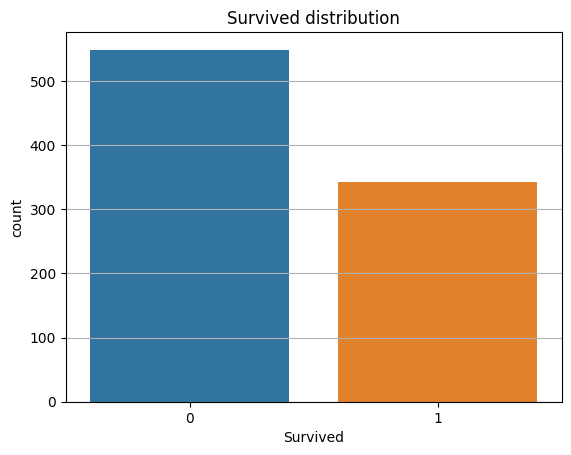

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)

# First at all, we plot target distribution
sns.countplot(x='Survived', data=train_df)
plt.title("Survived distribution")
plt.grid(axis='y')

warnings.resetwarnings()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


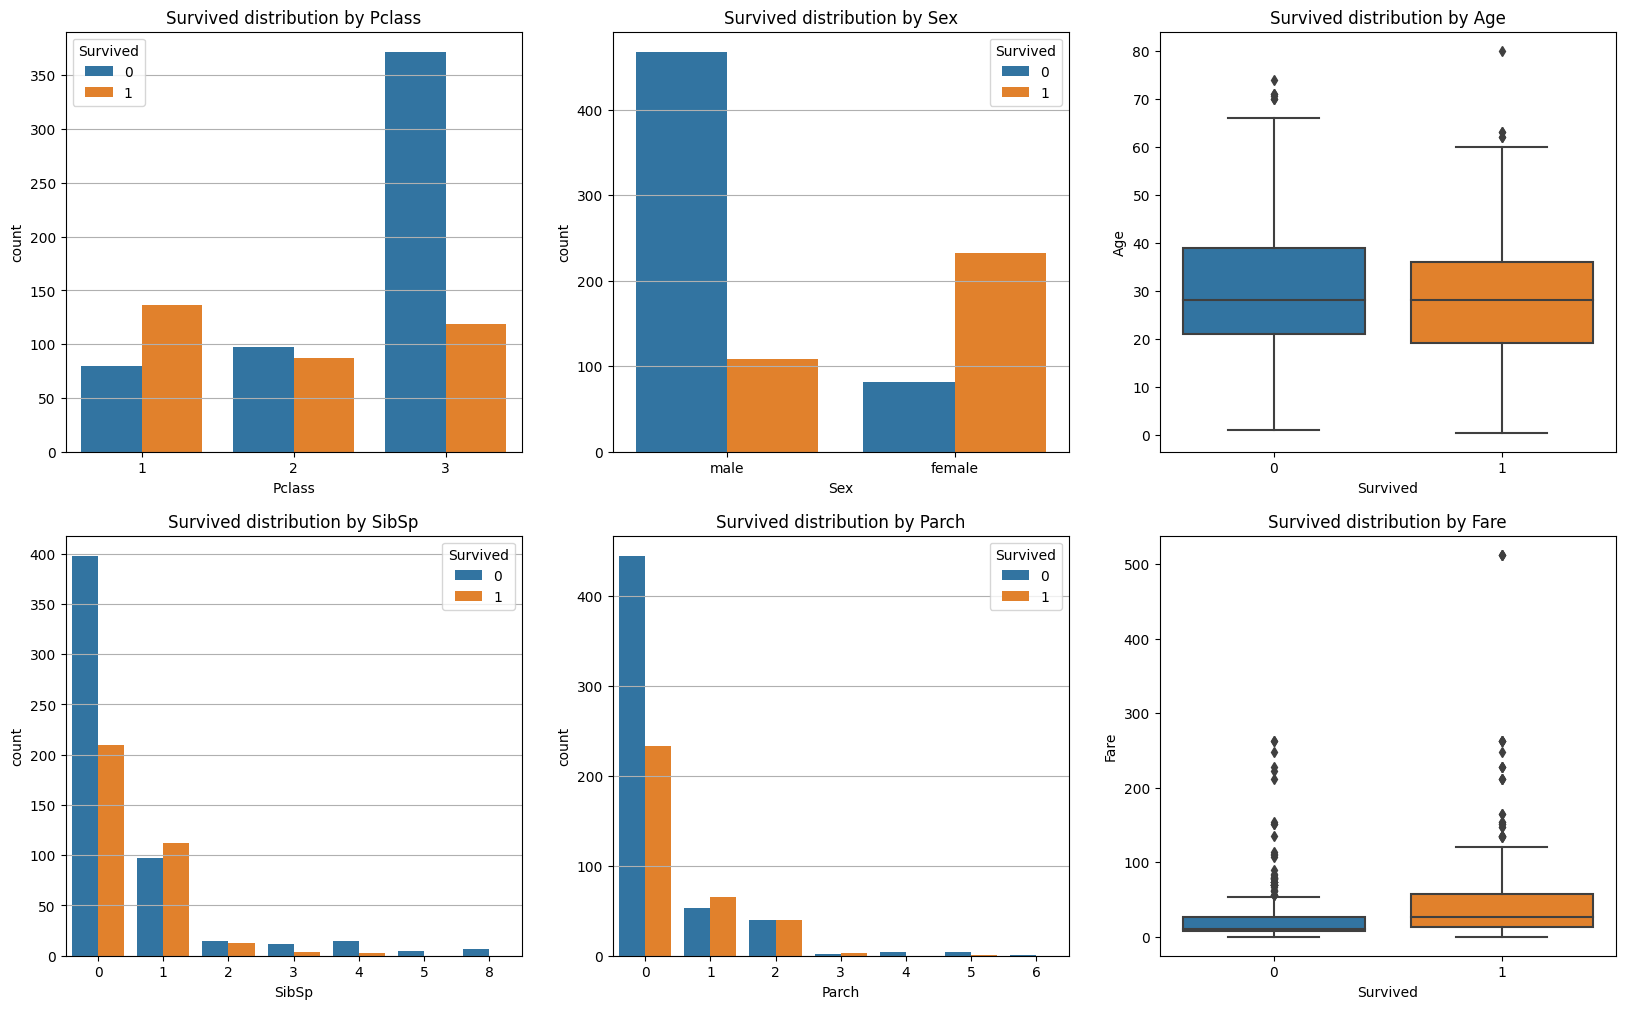

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))

# Convert the Survived column to a string object
train_df['Survived'] = train_df['Survived'].astype(str)

# Now, we plot the distribution of the target by Pclass
sns.countplot(x='Pclass', hue='Survived', data=train_df, ax=axs[0][0]);
axs[0][0].set_title('Survived distribution by Pclass')
axs[0][0].grid(axis='y')

# Plot the distribution of the target by Sex
sns.countplot(x='Sex', hue='Survived', data=train_df, ax=axs[0][1])
axs[0][1].set_title('Survived distribution by Sex')
axs[0][1].grid(axis='y')

# Plot the distribution of the target by Age
sns.boxplot(x='Survived', y='Age', data=train_df, ax=axs[0][2])
axs[0][2].set_title('Survived distribution by Age')

# Plot the distribution of the target by SibSp
sns.countplot(x='SibSp', hue='Survived', data=train_df, ax=axs[1][0])
axs[1][0].set_title('Survived distribution by SibSp')
axs[1][0].grid(axis='y')

# Plot the distribution of the target by Parch
sns.countplot(x='Parch', hue='Survived', data=train_df, ax=axs[1][1])
axs[1][1].set_title('Survived distribution by Parch')
axs[1][1].grid(axis='y')

# Plot the distribution of the target by Fare
sns.boxplot(x='Survived', y='Fare', data=train_df, ax=axs[1][2])
axs[1][2].set_title('Survived distribution by Fare')

plt.show()

warnings.resetwarnings()

From the visualizations, we can observe several patterns, such as:

- A higher proportion of females survived compared to males.
- Higher passenger classes (i.e., 1st class) seem to have a higher survival rate.
- Age, fare, and the number of siblings/spouses (SibSp) and parents/children (Parch) aboard also show variations in the survival rates.

Pairplot:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


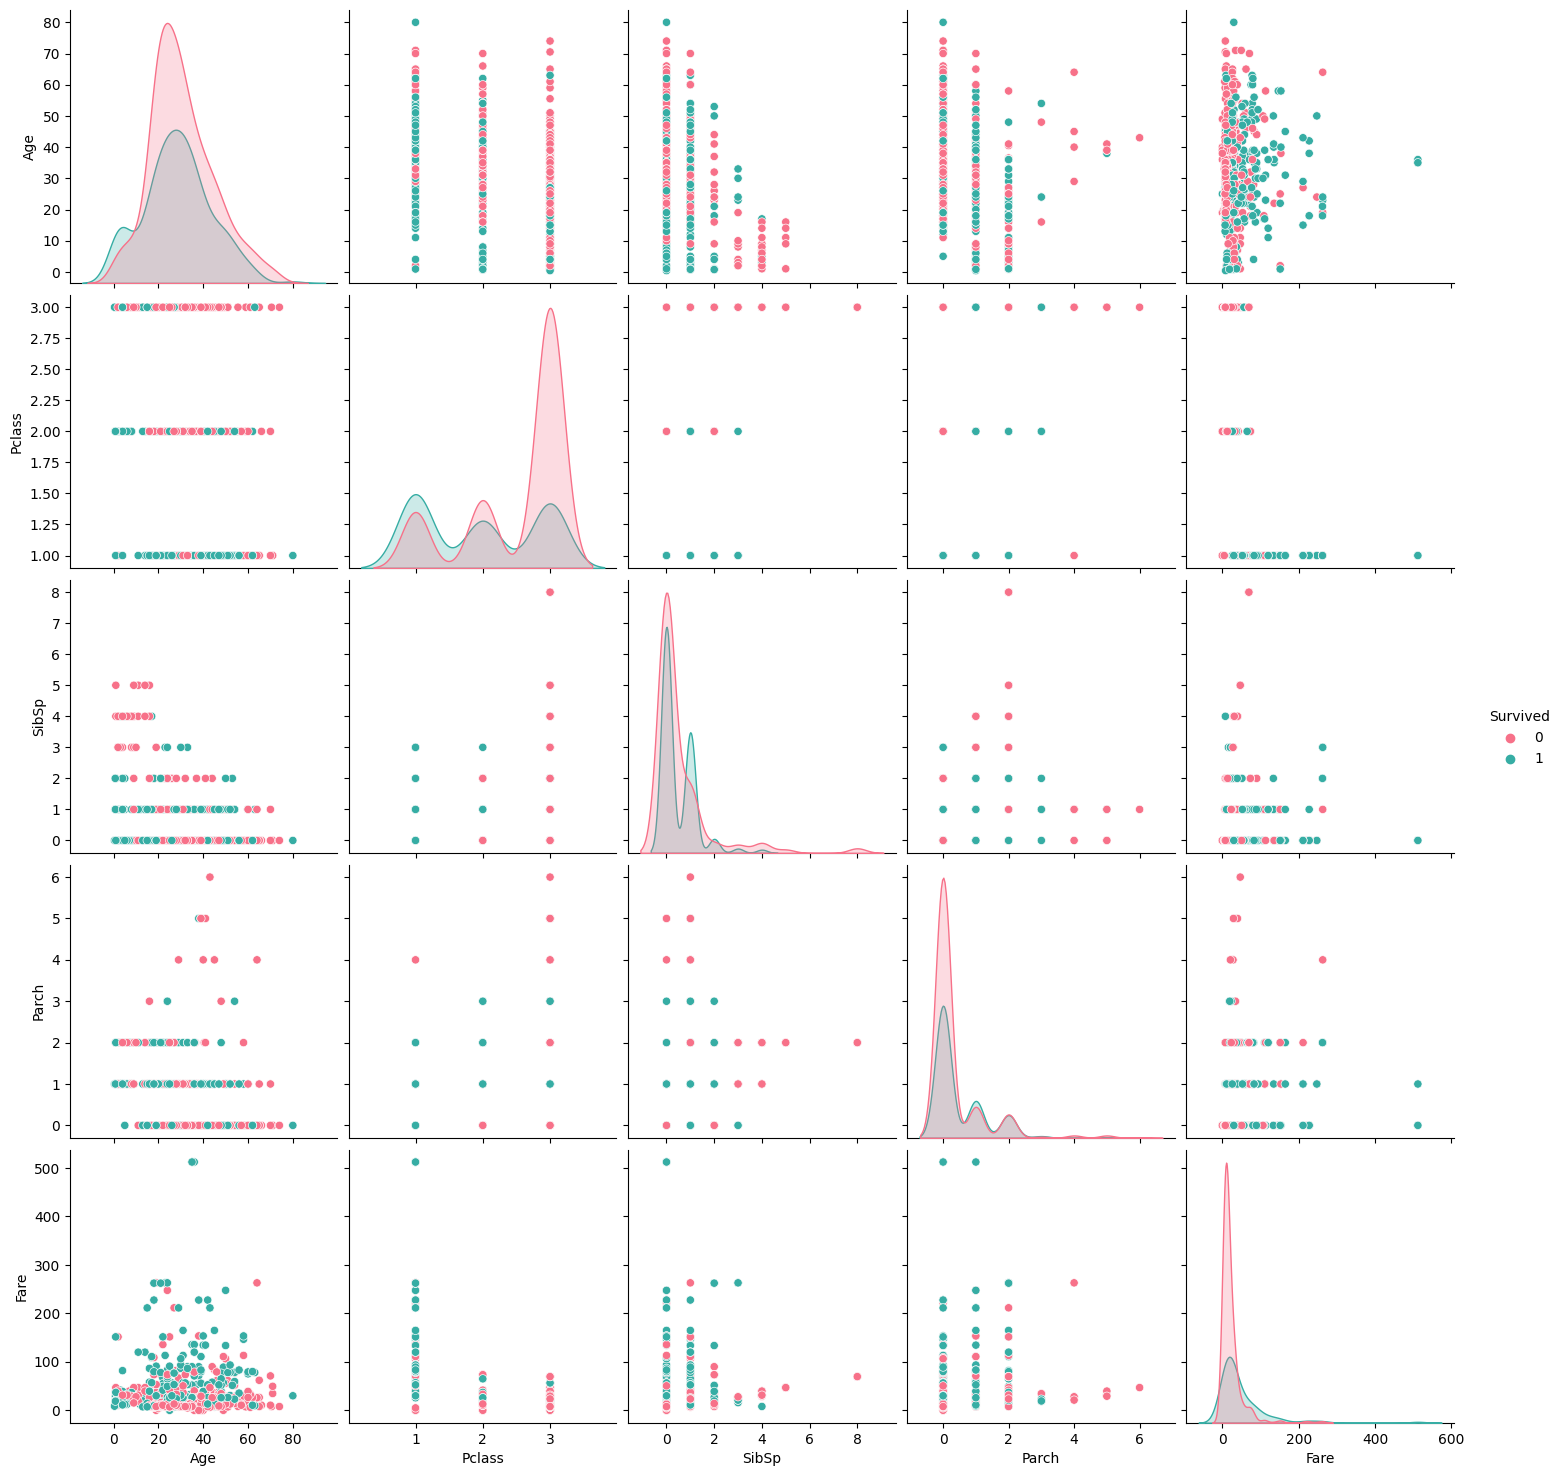

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Representa el pairplot
sns.pairplot(train_df, hue = 'Survived', vars = ["Age", "Pclass", "SibSp", "Parch", "Fare"], palette = 'husl', diag_kind = 'kde', kind = 'scatter', height=3);

warnings.resetwarnings()

### 5. Correlation matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


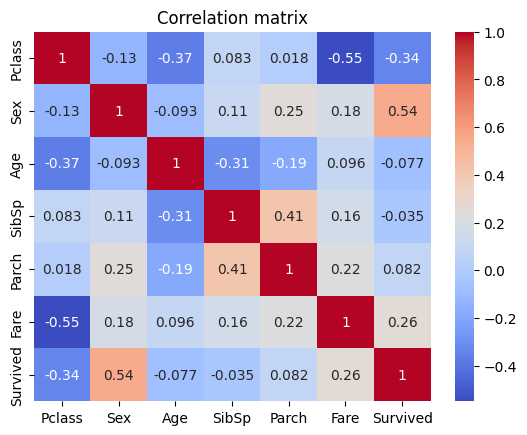

In [ ]:
# Convert the 'Sex' column to numerical values for correlation calculation
corr_df = train_df.copy()
corr_df['Sex'] = corr_df['Sex'].map({'male': 0, 'female': 1})
corr_df['Survived'] = corr_df['Survived'].astype(int)

corr_matrix = corr_df.corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation matrix')
plt.show()

### 6. Handling missing values

Let's fill the missing values in the `Age` column with the mean age based on `Sex` and `Pclass`.

In [ ]:
# Group by Sex and Pclass and calculate the mean of Age
mean_ages = train_df.groupby(['Sex', 'Pclass'])['Age'].mean()

# Define function to fill missing values for age
def fill_age(row):
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'], row['Pclass']]
    else:
        return row['Age']

train_df['Age'] = train_df.apply(fill_age, axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Check if there are missing values
train_df['Age'].isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

In [ ]:
train_df.to_csv(
    '/content/drive/MyDrive/Formació/Data Science + Machine Learning/Kaggle/data/titanic/train_clean.csv',
    index=False
);

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


## Data Preprocessing

Let's load the data again:



In [ ]:
titanic_data = pd.read_csv(
    '/content/drive/MyDrive/Formació/Data Science + Machine Learning/Kaggle/data/titanic/train_clean.csv'
)

First at all, le'ts encode the categorical features.

In [ ]:
titanic_data_encoded = pd.get_dummies(titanic_data, columns=["Sex", "Pclass"], drop_first=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
titanic_data_encoded.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Age,SibSp,Parch,Fare,Survived,Sex_male,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,0,1,0,1
1,38.0,1,0,71.2833,1,0,0,0
2,26.0,0,0,7.9250,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,0
4,35.0,0,0,8.0500,0,1,0,1


Let's create features and target dataframes

In [ ]:
X = titanic_data_encoded.drop('Survived', axis=1)
y = titanic_data_encoded['Survived'];

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Modeling with Logistic Regression

Let's focus in Logistic Regression in this notebook, we'll try different seeds and perform a grid search for finding the best parameters for this model.

In [ ]:
warnings.filterwarnings('ignore')

seeds = [0, 1, 42, 50, 123]

scalers = [
    ('Standard Scaler', StandardScaler()),
    ('MinMax Scaler', MinMaxScaler())
]

# Results from GridSearch
results_gs = []

# Loop for every seed
for seed in seeds:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

    # Define paramgrid for this model
    param_grid = {
        'C': np.logspace(-4, 4, 10),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l1', 'l2', 'elasticnet', 'None']
    }

    for name_scaler, scaler in scalers:

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        lr_clf = LogisticRegression(max_iter=1000, random_state=seed)

        # Initialize the grid search
        grid_search = GridSearchCV(lr_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_pred, y_test)

        result = {
            'seed': seed,
            'scaler': name_scaler,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'accuracy': accuracy
        }

        results_gs.append(result)


warnings.resetwarnings()

In [ ]:
results_df = pd.DataFrame(results_gs)

results_df.sort_values(by='accuracy', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,seed,scaler,best_params,best_score,accuracy
0,0,Standard Scaler,"{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}",0.804103,0.820896
1,0,MinMax Scaler,"{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}",0.804103,0.820896
9,123,MinMax Scaler,"{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}",0.799342,0.809701
2,1,Standard Scaler,"{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}",0.812232,0.805970
3,1,MinMax Scaler,"{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}",0.812232,0.805970
4,42,Standard Scaler,"{'C': 0.3593813663804626, 'penalty': 'l2', 'solver': 'liblinear'}",0.800942,0.805970
5,42,MinMax Scaler,"{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}",0.800916,0.805970
8,123,Standard Scaler,"{'C': 0.3593813663804626, 'penalty': 'l1', 'solver': 'saga'}",0.800942,0.798507
6,50,Standard Scaler,"{'C': 2.782559402207126, 'penalty': 'l2', 'solver': 'newton-cg'}",0.808916,0.776119
7,50,MinMax Scaler,"{'C': 21.54434690031882, 'penalty': 'l2', 'solver': 'liblinear'}",0.808916,0.776119


Let's try with `seed=0`and `StandardScaler` where we have better results

## Evaluating the model

Let's create pipeline for de model:

In [ ]:
best_seed = results_df['seed'][0]
best_params = results_df['best_params'][0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=best_seed)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        C=best_params['C'],
        penalty=best_params['penalty'],
        solver=best_params['solver'],
        random_state=best_seed
    ))
])

pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.0001, penalty='none', random_state=0,
                                    solver='newton-cg'))])

Now let's evaluate de model:

In [ ]:
y_pred = pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy score is: {accuracy*100:.2f} %");

Accuracy score is: 82.09 %


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       165
           1       0.82      0.69      0.75       103

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Confusion Matrix:

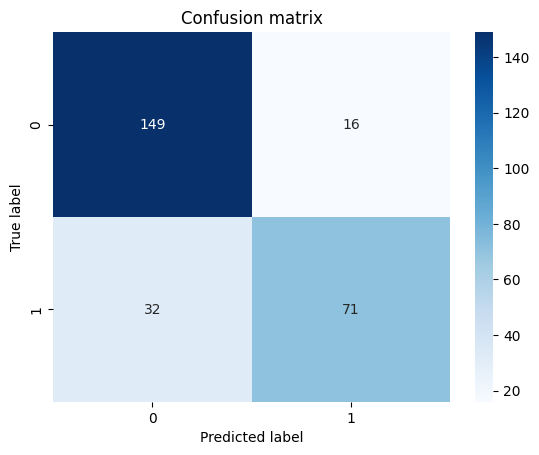

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g');
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');

Let's plot ROC curves and the AUC

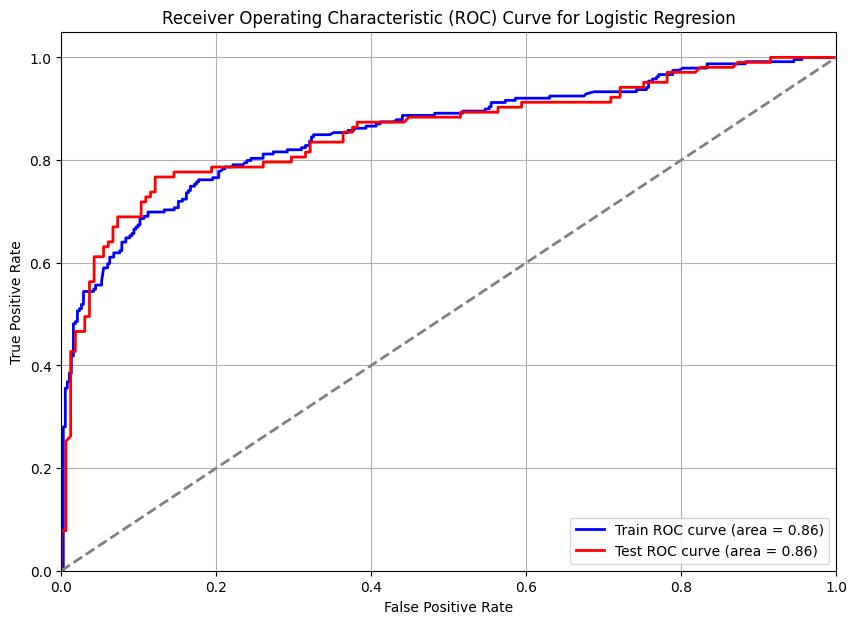

In [ ]:
# Get the probabilities of the positive class for training and testing data
train_probs = pipe.predict_proba(X_train)[:, 1]
test_probs = pipe.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate the ROC curve for test data
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Set up the figure and axis for the plot, with a specified size
plt.figure(figsize=(10, 7))

# Plot the ROC curve for the training data
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')

# Plot the ROC curve for the testing data
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')

# Plot a gray dashed line representing random guessing
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Set the limits of the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Label the axes and the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for Logistic Regresion')

# Add a legend to the plot
plt.legend(loc='lower right')

# Add a grid to the plot
plt.grid(True)

# Display the plot
plt.show()

We don't have overfitting, so it's a good model, but the accuracy is not very high.